# Supplemental Figures

## Setup

### imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
)

In [16]:
DATA_PATH = "../../data"

In [17]:
df_construct = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1_combined.json"
)
df_construct_2 = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2_combined.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

In [18]:
df["z_score"] = 0
df["r_data_outlier"] = False
data = []
for i, g in df.groupby(["m_sequence", "r_loc_pos"]):
    g["z_score"] = zscore(g["r_data"])
    g["r_data_outlier"] = g["z_score"].abs() > 3
    data.append(g)
df = pd.concat(data)
df = df.query("r_data_outlier == False").copy()

### extra functions

## Plotting

### Supplementary Figure XXX: reactivity vs standard dev

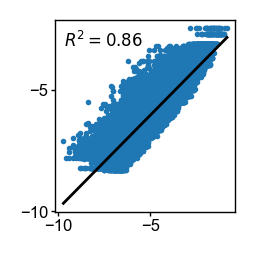

In [22]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
format_small_plot(ax)

### Supplemental Figure XXX: pdb flanking pairs still favor As

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(2.5, 2.5))
plt.subplots_adjust(
    hspace=0.55
)  # Increase hspace to add more vertical space between plots
axs = ax.flatten()
df_sub = df.query('m_sequence == "CCC&GAG"')
plot_motif_boxplot_stripplot(df_sub, ax=ax[0])
df_sub = df.query('m_sequence == "GCG&CC"')
plot_motif_boxplot_stripplot(df_sub, ax=ax[1])
axs[1].set_xlabel("Nucleotide")
for ax in axs:
    ax.set_ylabel("")
    ax.set_ylim(0, 0.05)
    publication_style_ax(ax)
fig.text(
    -0.15,
    0.5,
    "Mutation Fraction",
    va="center",
    rotation="vertical",
    fontsize=14,
    name="Arial",
)